# xAI - Aplicando SHAP, Grad-CAM e LIME para explicabilidade no dataset ImageWoof (subset do ImageNet)
---

## Instalando as principais bibliotecas utilizadas no projeto:

In [1]:
!pip install torch torchvision timm numpy matplotlib scikit-image lime shap grad-cam fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch
from torchvision import models, transforms
import timm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
import tarfile
from pathlib import Path

# --- Configurações Iniciais ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando o dispositivo: {device}")

# --- Download e Preparação do Dataset (Imagewoof) ---
def get_imagewoof_data():
    """Baixa e extrai o dataset Imagewoof."""
    path = Path.home() / ".fastai" / "data"
    path.mkdir(exist_ok=True, parents=True)
    file_path = path / "imagewoof2-320.tgz"

    if not file_path.exists():
        print("Baixando o dataset Imagewoof...")
        url = "https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz"
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(file_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Download completo. Extraindo...")

    data_path = path / "imagewoof2-320"
    if not data_path.exists():
        with tarfile.open(file_path, 'r:gz') as tar:
            tar.extractall(path=path)

    print(f"Dataset pronto em: {data_path}")
    return data_path / "train", data_path / "val"

train_path, val_path = get_imagewoof_data()

Usando o dispositivo: cuda
Dataset pronto em: /root/.fastai/data/imagewoof2-320


In [4]:
import requests
import json
import gc

# Função para carregar uma imagem de amostra
def load_image(image_path):
    """Carrega e pré-processa uma imagem."""
    img = Image.open(image_path).convert('RGB')
    return img, preprocess(img).unsqueeze(0)


def get_models():
    """Carrega todos os modelos pré-treinados e os coloca em modo de avaliação."""
    models_dict = {
        "ResNet50": models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
        "VGG16": models.vgg16(weights=models.VGG16_Weights.DEFAULT),
        "InceptionV3": torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', weights=models.Inception_V3_Weights.DEFAULT),
        "EfficientNet-B0": timm.create_model('efficientnet_b0', pretrained=True),
        "ViT-Base/16": timm.create_model('vit_base_patch16_224', pretrained=True)
    }

    for name, model in models_dict.items():
        model.to(device)
        model.eval()
        # InceptionV3 requer um tratamento especial
        if name == "InceptionV3":
            model.transform_input = False

    return models_dict

# Função para baixar e carregar os rótulos (nomes das classes) do ImageNet
def get_imagenet_labels():
    """Baixa e retorna a lista de nomes de classes do ImageNet."""
    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    try:
        response = requests.get(url)
        response.raise_for_status()
        # Os rótulos estão um por linha
        labels = [line.strip() for line in response.text.split('\n')]
        return labels
    except requests.RequestException as e:
        print(f"Erro ao baixar os rótulos do ImageNet: {e}")
        return None

def clear_garbage():
    gc.collect() # Chama o "coletor de lixo"
    torch.cuda.empty_cache() # Limpa o cache da GPU também

# Carrega os rótulos uma vez para usar depois
imagenet_labels = get_imagenet_labels()

In [5]:
# --- Transformações de Imagem ---
# Modelos pré-treinados no ImageNet esperam imagens normalizadas
# com média e desvio padrão específicos.
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [6]:
# Carregando uma imagem de exemplo para explicação
sample_image_path = list(val_path.glob('*/*.JPEG'))[0]
original_img, input_tensor = load_image(sample_image_path)
input_tensor = input_tensor.to(device)

print(f"\nImagem de exemplo carregada: {sample_image_path}")


Imagem de exemplo carregada: /root/.fastai/data/imagewoof2-320/val/n02115641/n02115641_8310.JPEG


In [7]:
# --- Carregamento dos Modelos ---
models_dict = get_models()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Grad-CAM:
---

In [19]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# --- Mapeamento das Camadas-Alvo para Grad-CAM ---
# Estas são as últimas camadas convolucionais (ou equivalentes para ViT)
target_layers_map = {
    "ResNet50": lambda m: [m.layer4[-1]],
    "VGG16": lambda m: [m.features[-1]],
    "InceptionV3": lambda m: [m.Mixed_7c],
    "EfficientNet-B0": lambda m: [m.conv_head],
    "ViT-Base/16": lambda m: [m.blocks[-1].norm1] # Camada alvo para ViT
}

from torchvision import transforms # Garanta que a transforms está importada

def apply_grad_cam(model, model_name, input_tensor, original_img, labels):
    """
    Aplica Grad-CAM e retorna a visualização, a classe predita e a confiança.
    """
    target_layers = target_layers_map[model_name](model)
    cam = GradCAM(model=model, target_layers=target_layers)

    # 1. Obter a saída completa do modelo (logits)
    outputs = model(input_tensor.to(device))

    # 2. Calcular as probabilidades com Softmax
    probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # 3. Obter a maior probabilidade e o índice da classe correspondente
    confidence, predicted_idx_tensor = torch.max(probabilities, 1)

    predicted_idx = predicted_idx_tensor.item()
    confidence_score = confidence.item()

    # 4. Mapear o índice para o nome da classe
    predicted_label = "Rótulo não encontrado"
    if labels and predicted_idx < len(labels):
        predicted_label = labels[predicted_idx]

    # Define a classe-alvo para o Grad-CAM usando o índice que acabamos de encontrar
    targets = [ClassifierOutputTarget(predicted_idx)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    vis_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224)
    ])
    resized_original_img = vis_transform(original_img)

    visualization = show_cam_on_image(
        np.array(resized_original_img, dtype=np.float32) / 255.0,
        grayscale_cam,
        use_rgb=True
    )

    # Retorna as novas informações
    return visualization, predicted_label, confidence_score

Gerando Grad-CAM para ResNet50...



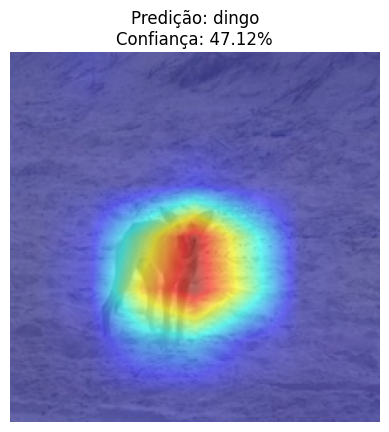

In [24]:
# Exemplo de uso para um modelo
print("Gerando Grad-CAM para ResNet50...", end='\n\n')

# --- MUDANÇA NA CHAMADA ---
# Agora desempacotamos os 3 valores retornados
grad_cam_result, pred_label, confidence = apply_grad_cam(
    models_dict["ResNet50"],
    "ResNet50",
    input_tensor,
    original_img,
    imagenet_labels # Passamos os rótulos para a função
)

plt.imshow(grad_cam_result)

# Cria um título formatado com a predição e a confiança
# O formato :.2% multiplica por 100 e adiciona o % com 2 casas decimais
title_text = f"Predição: {pred_label}\nConfiança: {confidence:.2%}"
plt.title(title_text)
plt.axis('off')
plt.show()

LIME:
---


Gerando LIME para ResNet50...


  0%|          | 0/1000 [00:00<?, ?it/s]

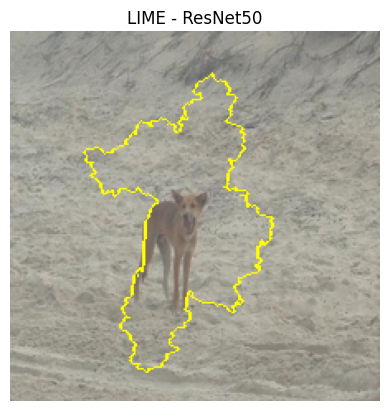

In [27]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def apply_lime(model, input_tensor, original_img):
    """Aplica e visualiza o LIME."""
    explainer = lime_image.LimeImageExplainer()

    # Função de predição para o LIME
    def batch_predict(images):
        # O LIME passa imagens como (N, H, W, C) no formato numpy
        # Precisamos converter para o formato do PyTorch: (N, C, H, W)
        model.eval()
        batch = torch.stack([transforms.ToTensor()(img) for img in images], dim=0)
        batch = batch.to(device)

        # Normalização necessária
        norm_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        batch = torch.stack([norm_transform(img) for img in batch])

        logits = model(batch)
        probs = torch.nn.functional.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()

    # Gera a explicação
    explanation = explainer.explain_instance(
        np.array(original_img.resize((224, 224))),
        batch_predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000 # Número de amostras para gerar perturbações
    )

    # Visualiza as regiões mais importantes sobre a imagem original
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    # A variável 'temp' agora é a imagem original.
    # mark_boundaries vai desenhar os contornos (mask) sobre ela.
    lime_visualization = mark_boundaries(temp, mask)

    return lime_visualization

# Exemplo de uso para um modelo
print("\nGerando LIME para ResNet50...")
lime_result = apply_lime(models_dict["ResNet50"], input_tensor, original_img)

plt.imshow(lime_result)
plt.title("LIME - ResNet50")
plt.axis('off')
plt.show()

## SHAP:
---

In [9]:
import torch
from torchvision import models

class ModelWrapper(torch.nn.Module):
    """
    Wrapper para garantir que o modelo retorne apenas um tensor de logits,
    compatível com bibliotecas como SHAP.
    """
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        output = self.model(x)
        # Verifica se a saída é a tupla específica da InceptionV3
        if isinstance(output, models.inception.InceptionOutputs):
            return output.logits
        # Para outros modelos, a saída já deve ser um tensor
        return output

### SHAPs problemáticos para ResNet50:
---

#### GradientSHAP:

In [28]:
import shap
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

def apply_shap(model, input_tensor, original_img, train_path):
    """Aplica e visualiza o SHAP."""
    # 1. Preparar um background dataset para o SHAP
    # Pegamos um pequeno lote de imagens do dataset de treino
    dataset = ImageFolder(train_path, transform=preprocess)
    loader = DataLoader(dataset, batch_size=50, shuffle=True)
    background, _ = next(iter(loader))
    background = background.to(device)

    # 2. Criar o explainer do SHAP
    explainer = shap.GradientExplainer(model, background)

    # 3. Calcular os valores SHAP para a nossa imagem de exemplo
    # O SHAP espera um tensor com a classe-alvo (pode ser a classe predita)
    output = model(input_tensor)
    _, pred_index = torch.max(output, 1)

    shap_values = explainer.shap_values(input_tensor, nsamples=200, ranked_outputs=1)

    # 4. Visualizar a explicação
    # O SHAP para imagens retorna os valores como (N, C, H, W).
    # Precisamos ajustar os eixos para (N, H, W, C) para plotagem.
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(input_tensor.cpu().numpy(), 1, -1), 1, 2)

    # Plotar a explicação sobre a imagem original
    shap.image_plot(shap_numpy, -test_numpy) # Usamos -test_numpy para uma melhor visualização

# Exemplo de uso para um modelo
# Nota: SHAP pode ser computacionalmente intenso.
print("\nGerando SHAP para ResNet50...")
apply_shap(models_dict["ResNet50"], input_tensor, original_img, train_path)


Gerando SHAP para ResNet50...


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [31]:
import shap
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np

def apply_shap(model, input_tensor, original_img, train_path):
    """Aplica e visualiza o SHAP usando um wrapper de modelo."""

    # --- INÍCIO DA CORREÇÃO ---
    # 1. Embrulhar o modelo para garantir uma saída compatível
    wrapped_model = ModelWrapper(model).to(device)
    wrapped_model.eval() # Garante que o wrapper esteja em modo de avaliação
    # --- FIM DA CORREÇÃO ---

    # 2. Preparar um background dataset para o SHAP
    dataset = ImageFolder(train_path, transform=preprocess)
    loader = DataLoader(dataset, batch_size=50, shuffle=True)
    background, _ = next(iter(loader))
    background = background.to(device)

    # 3. Criar o explainer do SHAP usando o modelo embrulhado
    explainer = shap.GradientExplainer(wrapped_model, background)

    # 4. Calcular os valores SHAP para a nossa imagem de exemplo
    # O parâmetro 'nsamples' não é usado pelo GradientExplainer, pode ser removido.
    shap_values = explainer.shap_values(input_tensor.to(device), ranked_outputs=1)

    # 5. Visualizar a explicação
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(input_tensor.cpu().numpy(), 1, -1), 1, 2)

    print("Plotando a explicação SHAP...")
    shap.image_plot(shap_numpy, -test_numpy, show=False)

# Exemplo de uso
print("\nGerando SHAP para ResNet50...")
# Passamos o modelo original, a função se encarrega de embrulhá-lo
apply_shap(models_dict["ResNet50"], input_tensor, original_img, train_path)
plt.show() # Mostra o gráfico gerado pelo shap.image_plot


Gerando SHAP para ResNet50...


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

#### DeepSHAP:

In [32]:
import shap
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import torch
# Supondo que a classe ModelWrapper já foi definida como na resposta anterior
# e que 'preprocess', 'device', etc. estão definidos.

def apply_shap(model, input_tensor, original_img, train_path):
    """Aplica e visualiza o SHAP usando DeepExplainer."""

    # 1. Embrulhar o modelo para garantir uma saída compatível (ainda é uma boa prática)
    wrapped_model = ModelWrapper(model).to(device)
    wrapped_model.eval()

    # 2. Preparar um background dataset. É importante que o background
    # represente a distribuição média das imagens.
    # Usar um número menor de imagens de fundo (ex: 10-20) pode acelerar o processo.
    dataset = ImageFolder(train_path, transform=preprocess)
    loader = DataLoader(dataset, batch_size=20, shuffle=True)
    background, _ = next(iter(loader))
    background = background.to(device)

    # --- INÍCIO DA MUDANÇA PRINCIPAL ---

    # 3. Criar o explainer do SHAP usando DeepExplainer
    explainer = shap.DeepExplainer(wrapped_model, background)

    # 4. Calcular os valores SHAP.
    # DeepExplainer não usa 'ranked_outputs'. Ele calcula os valores para todas as classes.
    shap_values = explainer.shap_values(input_tensor.to(device))

    # --- FIM DA MUDANÇA PRINCIPAL ---

    # 5. Visualizar a explicação.
    # A sua lógica de 'swapaxes' está correta para formatar os dados para o plot.
    # shap_values agora é uma lista de 1000 arrays (um por classe).
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(input_tensor.cpu().numpy(), 1, -1), 1, 2)

    print("Plotando a explicação SHAP...")
    # O shap.image_plot é inteligente. Ele identificará a classe com maior predição
    # e usará os SHAP values correspondentes para a plotagem.
    shap.image_plot(shap_numpy, -test_numpy, show=False)


# Exemplo de uso
print("\nGerando SHAP para ResNet50...")
apply_shap(models_dict["ResNet50"], input_tensor, original_img, train_path)
plt.show()


Gerando SHAP para ResNet50...


RuntimeError: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is forbidden. You can fix this by cloning the output of the custom Function.

In [33]:
import shap
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import torch

# Supondo que ModelWrapper, preprocess, device, etc., já estão definidos.

def apply_shap(model, input_tensor, original_img, train_path):
    """Aplica e visualiza o SHAP, desativando operações inplace."""

    # --- INÍCIO DA NOVA CORREÇÃO ---
    # Desativar operações "inplace" no modelo, pois elas conflitam com os hooks do SHAP.
    # Esta é a correção para o erro "modified inplace".
    print("Desativando operações 'inplace' no modelo para compatibilidade com SHAP...")
    for module in model.modules():
        if hasattr(module, 'inplace'):
            module.inplace = False
    # --- FIM DA NOVA CORREÇÃO ---

    # 1. Embrulhar o modelo (ainda é uma boa prática)
    wrapped_model = ModelWrapper(model).to(device)
    wrapped_model.eval()

    # 2. Preparar um background dataset
    dataset = ImageFolder(train_path, transform=preprocess)
    loader = DataLoader(dataset, batch_size=20, shuffle=True)
    background, _ = next(iter(loader))
    background = background.to(device)

    # 3. Criar o explainer do SHAP usando DeepExplainer
    explainer = shap.DeepExplainer(wrapped_model, background)

    # 4. Calcular os valores SHAP
    shap_values = explainer.shap_values(input_tensor.to(device))

    # 5. Visualizar a explicação
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(input_tensor.cpu().numpy(), 1, -1), 1, 2)

    print("Plotando a explicação SHAP...")
    shap.image_plot(shap_numpy, -test_numpy, show=False)

# Exemplo de uso
print("\nGerando SHAP para ResNet50...")
apply_shap(models_dict["ResNet50"], input_tensor, original_img, train_path)
plt.show()


Gerando SHAP para ResNet50...
Desativando operações 'inplace' no modelo para compatibilidade com SHAP...


RuntimeError: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is forbidden. You can fix this by cloning the output of the custom Function.

### KernelSHAP:


Gerando SHAP para ResNet50 (versão final)...
Calculando SHAP values com a API moderna (isso pode ser lento)...
Plotando a explicação SHAP...


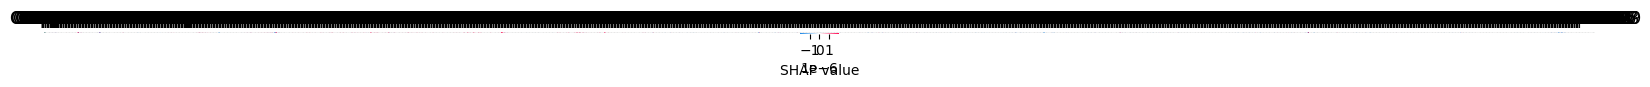

In [12]:
import shap
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Supondo que ModelWrapper, preprocess, device, etc., já estão definidos.

def apply_shap_final(model, input_tensor, original_img):
    """
    Aplica e visualiza o SHAP usando a API moderna e os formatos de dados corretos.
    """

    # 1. Preparar o modelo e a função de predição (sem alterações)
    wrapped_model = ModelWrapper(model).to(device)
    wrapped_model.eval()

    def predict_fn(numpy_images):
        preprocess_for_shap = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        # A entrada já será um numpy array (N, H, W, C), astype(np.uint8) é importante
        tensor_images = torch.stack([preprocess_for_shap(img) for img in numpy_images.astype(np.uint8)])
        tensor_images = tensor_images.to(device)

        with torch.no_grad():
            logits = wrapped_model(tensor_images)

        probs = torch.nn.functional.softmax(logits, dim=1)
        return probs.cpu().numpy()

    # --- INÍCIO DA CORREÇÃO ---

    # 2. Corrigir a forma passada para o masker.
    #    Deve ser (altura, largura, canais).
    masker = shap.maskers.Image("blur(224,224)", shape=(224, 224, 3))

    # 3. Criar o Explainer de alto nível (sem alterações)
    explainer = shap.Explainer(predict_fn, masker)

    # 4. Converter o tensor de entrada para o formato esperado pelo SHAP (N, H, W, C)
    #    O PyTorch usa (N, C, H, W), precisamos transpor os eixos.
    input_numpy_chw = input_tensor.cpu().numpy()
    input_numpy_hwc = input_numpy_chw.transpose(0, 2, 3, 1)

    # 5. Calcular os valores SHAP usando o array numpy no formato correto.
    print("Calculando SHAP values com a API moderna (isso pode ser lento)...")
    shap_values = explainer(
        input_numpy_hwc,
        max_evals=64,
        main_effects=False
    )

    # --- FIM DA CORREÇÃO ---

    # 6. Visualizar a explicação.
    #    O objeto 'shap_values' já contém a imagem de fundo no formato correto.
    print("Plotando a explicação SHAP...")
    shap.image_plot(
        shap_values,
        show=False
    )

# Exemplo de uso
print("\nGerando SHAP para ResNet50 (versão final)...")
# Redimensiona a imagem de entrada para o formato que a função espera
resized_img_tensor = preprocess(original_img).unsqueeze(0)

# Chama a nova função
apply_shap_final(models_dict["ResNet50"], resized_img_tensor, original_img)
plt.show()

In [ ]:
import shap
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Supondo que ModelWrapper, preprocess, device, etc., já estão definidos.

def apply_shap_final(model, input_tensor, original_img, imagenet_labels):
    """
    Aplica e visualiza o SHAP com sobreposição na imagem, similar a Grad-CAM/LIME.
    """

    # 1. Preparar o modelo e a função de predição (sem alterações)
    wrapped_model = ModelWrapper(model).to(device)
    wrapped_model.eval()

    def predict_fn(numpy_images):
        preprocess_for_shap = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        tensor_images = torch.stack([preprocess_for_shap(img) for img in numpy_images.astype(np.uint8)])
        tensor_images = tensor_images.to(device)

        with torch.no_grad():
            logits = wrapped_model(tensor_images)

        probs = torch.nn.functional.softmax(logits, dim=1)
        return probs.cpu().numpy()

    # 2. Criar a máscara (sem alterações)
    masker = shap.maskers.Image("blur(224,224)", shape=(224, 224, 3))

    # 3. Criar o Explainer (sem alterações)
    explainer = shap.Explainer(predict_fn, masker)

    # 4. Converter o tensor de entrada para o formato esperado (N, H, W, C)
    input_numpy_chw = input_tensor.cpu().numpy()
    input_numpy_hwc = input_numpy_chw.transpose(0, 2, 3, 1)

    # 5. Calcular os valores SHAP
    print("Calculando SHAP values com a API moderna (isso pode ser lento)...")
    shap_values_full = explainer(
        input_numpy_hwc,
        max_evals=32,
        main_effects=False
    )

    # --- INÍCIO DA MODIFICAÇÃO PARA A VISUALIZAÇÃO ---

    # 6. Obter o índice da classe predita
    with torch.no_grad():
        output = wrapped_model(input_tensor.to(device))
        predicted_index = torch.argmax(output, dim=1).item()

    # 7. Extrair os SHAP values para a classe predita
    shap_values_for_prediction = shap_values_full[:, :, :, predicted_index].values

    # 8. Preparar a imagem original para a visualização (formato numpy, entre 0 e 1)
    original_img_np = np.array(original_img.resize((224, 224)), dtype=np.float32) / 255.0

    # 9. Visualizar a explicação com sobreposição na imagem
    print("Plotando a explicação SHAP com sobreposição na imagem...")
    plt.figure()
    shap.image_plot(
        shap_values_for_prediction,
        original_img_np,
        show=False
    )

    # --- FIM DA MODIFICAÇÃO ---

# Exemplo de uso (certifique-se de ter imagenet_labels carregado)
print("\nGerando SHAP para ResNet50 com sobreposição na imagem...")
resized_img_tensor = preprocess(original_img).unsqueeze(0)

# Certifique-se de ter carregado as labels do ImageNet
# if 'imagenet_labels' not in locals():
#     imagenet_labels = get_imagenet_labels()

apply_shap_final(models_dict["ResNet50"], resized_img_tensor, original_img, imagenet_labels)
plt.show()


Gerando SHAP para ResNet50 com sobreposição na imagem...
Calculando SHAP values com a API moderna (isso pode ser lento)...



Gerando SHAP para ResNet50 (com plot final)...
Executando SHAP com plot manual (versão final)...
Calculando SHAP values com 128x128 e max_evals=32 (rápido)...


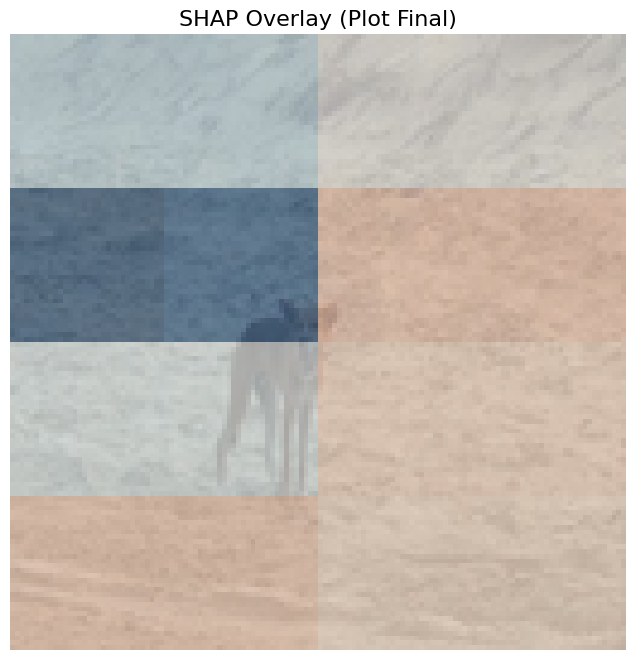

In [15]:
import shap
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

def plot_shap_overlay_final(shap_explanation, original_img_pil):
    """
    Função final e correta para plotar a sobreposição dos valores SHAP.
    Esta função entende o output de 5 dimensões do shap.Explainer.
    """
    # 1. Extrair os SHAP values. A forma é (N, H, W, C, Classes)
    shap_values = shap_explanation.values

    # 2. Encontrar o índice da classe com maior impacto somando os SHAP values
    #    Somamos nas dimensões de altura, largura e canais (1, 2, 3)
    top_output_index = np.argmax(np.sum(shap_values, axis=(0, 1, 2, 3)))

    # 3. Criar o heatmap 2D
    #    a) Seleciona os SHAP values para a classe de maior impacto
    #    b) Soma os valores através dos canais de cor (RGB) para ter um valor único por pixel
    heatmap = np.sum(shap_values[0, :, :, :, top_output_index], axis=-1)

    # 4. Redimensionar a imagem original para o mesmo tamanho do heatmap
    img_resized = original_img_pil.resize(heatmap.shape, Image.Resampling.LANCZOS)

    # 5. Normalizar o heatmap para a visualização ficar boa
    abs_max = np.percentile(np.abs(heatmap), 99.9)

    # 6. Plotar a sobreposição usando Matplotlib
    plt.figure(figsize=(8, 8))
    plt.title("SHAP Overlay (Plot Final)", fontsize=16)
    plt.imshow(img_resized)
    plt.imshow(heatmap, cmap='RdBu', vmin=-abs_max, vmax=abs_max, alpha=0.5)
    plt.axis('off')
    plt.show()


def apply_shap_manual_plot_final(model, original_img):
    """
    Calcula os valores SHAP e usa a função de plot final e correta.
    """
    print("Executando SHAP com plot manual (versão final)...")

    wrapped_model = ModelWrapper(model).to(device)
    wrapped_model.eval()

    img_size_light = 128
    preprocess_for_model = transforms.Compose([
        transforms.Resize((img_size_light, img_size_light)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    def predict_fn_light(numpy_images):
        tensor_images = torch.stack([preprocess_for_model(Image.fromarray(img)) for img in numpy_images.astype(np.uint8)])
        tensor_images = tensor_images.to(device)
        with torch.no_grad(): logits = wrapped_model(tensor_images)
        probs = torch.nn.functional.softmax(logits, dim=1)
        return probs.cpu().numpy()

    masker = shap.maskers.Image(f"blur({img_size_light},{img_size_light})", shape=(img_size_light, img_size_light, 3))
    explainer = shap.Explainer(predict_fn_light, masker)

    input_tensor_for_shap = preprocess_for_model(original_img).unsqueeze(0)
    input_numpy_for_shap = input_tensor_for_shap.permute(0, 2, 3, 1).cpu().numpy()

    print(f"Calculando SHAP values com {img_size_light}x{img_size_light} e max_evals=32 (rápido)...")
    shap_explanation_object = explainer(
        input_numpy_for_shap,
        max_evals=32,
        main_effects=False
    )

    # Chama nossa nova e correta função de plot manual
    plot_shap_overlay_final(shap_explanation_object, original_img)


# Exemplo de uso final
print("\nGerando SHAP para ResNet50 (com plot final)...")
apply_shap_manual_plot_final(models_dict["ResNet50"], original_img)


Gerando SHAP para ResNet50 (versão definitiva)...
Executando a versão definitiva do SHAP...
Calculando SHAP values com 128x128 e max_evals=200...


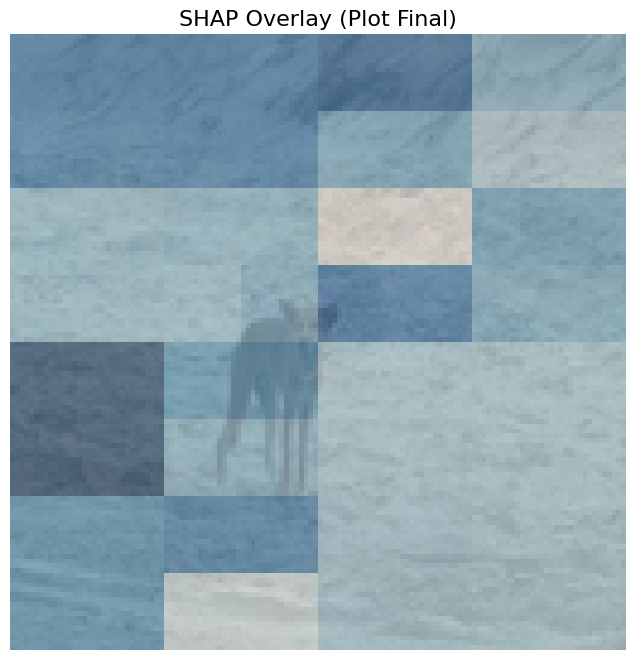

In [18]:
import shap
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from skimage.segmentation import slic

def apply_shap_definitive(model, original_img):
    """
    Aplica o SHAP com a correção final de dimensionalidade da máscara para
    garantir a execução sem erros.
    """
    print("Executando a versão definitiva do SHAP...")

    # Modelo e função de predição (sem alterações)
    wrapped_model = ModelWrapper(model).to(device)
    wrapped_model.eval()
    img_size_light = 128
    preprocess_for_model = transforms.Compose([
        transforms.Resize((img_size_light, img_size_light)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    def predict_fn_light(numpy_images):
        tensor_images = torch.stack([preprocess_for_model(Image.fromarray(img)) for img in numpy_images.astype(np.uint8)])
        tensor_images = tensor_images.to(device)
        with torch.no_grad(): logits = wrapped_model(tensor_images)
        probs = torch.nn.functional.softmax(logits, dim=1)
        return probs.cpu().numpy()

    # --- INÍCIO DA CORREÇÃO FINAL E DEFINITIVA ---

    # 4. Segmentar a imagem em 2D
    img_for_segmentation = np.array(original_img.resize((img_size_light, img_size_light)))
    segments_slic_2d = slic(img_for_segmentation, n_segments=50, compactness=10, sigma=1, start_label=1)

    # 5. TRANSFORMAR A MÁSCARA 2D EM 3D
    #    Nós empilhamos a mesma máscara 2D para cada um dos 3 canais de cor.
    segments_slic_3d = np.stack([segments_slic_2d, segments_slic_2d, segments_slic_2d], axis=-1)

    # 6. Criar o masker usando a nova máscara 3D
    #    O argumento 'shape' agora é redundante, mas não prejudica.
    masker = shap.maskers.Image(segments_slic_3d, shape=(img_size_light, img_size_light, 3))

    # --- FIM DA CORREÇÃO FINAL E DEFINITIVA ---

    explainer = shap.Explainer(predict_fn_light, masker)

    input_tensor_for_shap = preprocess_for_model(original_img).unsqueeze(0)
    input_numpy_for_shap = input_tensor_for_shap.permute(0, 2, 3, 1).cpu().numpy()

    print(f"Calculando SHAP values com {img_size_light}x{img_size_light} e max_evals=200...")
    shap_explanation_object = explainer(
        input_numpy_for_shap,
        max_evals=200,
        main_effects=False
    )

    # A nossa função de plot manual já está correta e vai funcionar com este output.
    plot_shap_overlay_final(shap_explanation_object, original_img)


# Exemplo de uso
print("\nGerando SHAP para ResNet50 (versão definitiva)...")
apply_shap_definitive(models_dict["ResNet50"], original_img)

In [ ]:
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

# 1. NOVOS IMPORTS DA CAPTUM
from captum.attr import GradientShap, visualization as viz
from captum.attr._utils.attribution import Attribution, GradientAttribution

# Supondo que ModelWrapper, original_img, device, etc., já estão definidos

def apply_captum_gradshap(model, input_tensor, original_img):
    """
    Aplica o GradientSHAP usando a biblioteca Captum para uma explicação
    rápida e de alta qualidade.
    """
    print("Executando GradientSHAP com a biblioteca Captum...")

    # 2. PREPARAR O MODELO
    # O ModelWrapper ainda é uma boa prática para garantir saídas consistentes.
    wrapped_model = ModelWrapper(model).to(device)
    wrapped_model.eval()

    # 3. INICIALIZAR O EXPLAINER DA CAPTUM
    # A inicialização é muito mais simples.
    gradient_shap = GradientShap(wrapped_model)

    # 4. OBTER A PREDIÇÃO E CRIAR UMA LINHA DE BASE (BASELINES)
    # O GradientSHAP precisa de uma "imagem de referência" ou linha de base.
    # Um tensor de zeros é a linha de base mais comum e eficaz.
    output = wrapped_model(input_tensor.to(device))
    predicted_index = torch.argmax(output, dim=1).item()

    # Cria uma linha de base com a mesma forma do input
    baselines = torch.zeros_like(input_tensor).to(device)

    # 5. CALCULAR A ATRIBUIÇÃO (EQUIVALENTE AOS SHAP VALUES)
    # É muito mais rápido que o KernelExplainer.
    print("Calculando atribuições do GradientSHAP...")
    attribution = gradient_shap.attribute(
        input_tensor.to(device),
        baselines=baselines,
        target=predicted_index
    )

    # A saída é um tensor. Vamos converter para numpy.
    attribution_np = attribution.squeeze(0).cpu().permute(1, 2, 0).numpy()

    # 6. VISUALIZAR USANDO A FERRAMENTA NATIVA DA CAPTUM
    print("Plotando a explicação...")
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Imagem Original
    axes[0].imshow(original_img)
    axes[0].set_title('Imagem Original')
    axes[0].axis('off')

    # Heatmap sobreposto
    viz.visualize_image_attr(
        attribution_np,
        original_image=np.array(original_img),
        method='blended_heat_map',
        sign='all',  # Mostra contribuições positivas (vermelho) e negativas (azul)
        alpha_overlay=0.6,
        show_colorbar=True,
        title='Explicação com GradientSHAP (Captum)',
        fig=fig,
        axes=axes[1],
        use_pyplot=False
    )
    plt.tight_layout()
    plt.show()


# Exemplo de uso final
print("\nGerando SHAP de alta qualidade para ResNet50 com Captum...")
# A Captum funciona com a imagem em resolução total
final_input_tensor = preprocess(original_img).unsqueeze(0)
apply_captum_gradshap(models_dict["ResNet50"], final_input_tensor, original_img)